# Autoencoder for CIFAR-10

In this exercise we're going to build an autoencoder aimed at learning features of CIFAR-10 dataset and see if its pretrained encoder part can be used at a basis for a classifier.

## Preparation

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

np.random.seed(16)
tf.random.set_seed(16)

In [2]:
from tensorflow.keras.datasets.cifar10 import load_data

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = load_data()

print(f'{X_train_full.shape = }')
print(f'{y_train_full.shape = }')
print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_train_full.shape = (50000, 32, 32, 3)
y_train_full.shape = (50000, 1)
X_test.shape = (10000, 32, 32, 3)
y_test.shape = (10000, 1)


In [4]:
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

In order to control overfitting we should use a validation data that is not test data left for the final error measure.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000)

In [6]:
nrows = ncols = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8))
for img, ax in zip(X_train, axs.ravel()):
    ax.imshow(img)
    ax.axis('off')

# Autoencoder

Now the model. This time let's try fitting denoising autoencoder so that the encoder should learn some non-visible features hidden in the image. We hope for it to make reasonable codings so that it can be used later as a part of a classifier trained on small subset of training data.

In [7]:
encoder = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.GaussianNoise(0.3),
    keras.layers.Dense(1000, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal')
])
decoder = keras.Sequential([
    keras.layers.Dense(1000, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(32*32*3, activation='sigmoid'),
    keras.layers.Reshape((32, 32, 3))
])

autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.SGD(0.1, 0.98, nesterov=True)
)

history = autoencoder.fit(X_train, X_train, epochs=50, validation_data=(X_val, X_val))

Epoch 1/50
1407/1407 [==============================] - 65s 46ms/step - loss: 0.0262 - val_loss: 0.0154
Epoch 2/50
1407/1407 [==============================] - 68s 49ms/step - loss: 0.0149 - val_loss: 0.0120
Epoch 3/50
1407/1407 [==============================] - 65s 46ms/step - loss: 0.0127 - val_loss: 0.0105
Epoch 4/50
1407/1407 [==============================] - 65s 46ms/step - loss: 0.0115 - val_loss: 0.0095
Epoch 5/50
1407/1407 [==============================] - 66s 47ms/step - loss: 0.0108 - val_loss: 0.0089
Epoch 6/50
1407/1407 [==============================] - 66s 47ms/step - loss: 0.0102 - val_loss: 0.0083
Epoch 7/50
1407/1407 [==============================] - 67s 48ms/step - loss: 0.0098 - val_loss: 0.0080
Epoch 8/50
1407/1407 [==============================] - 68s 48ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 9/50
1407/1407 [==============================] - 67s 48ms/step - loss: 0.0093 - val_loss: 0.0074
Epoch 10/50
1407/1407 [==============================] - 68s 48m

In [8]:
n_imgs = 6

idxs = np.random.choice(X_train.shape[0], size=n_imgs, replace=False)

imgs = X_train[idxs]
imgs_with_noise = imgs + np.random.normal(scale=0.3, size=imgs.shape)
imgs_with_noise = (imgs_with_noise - imgs_with_noise.min()) / (imgs_with_noise.max() - imgs_with_noise.min())  # normalization
reconstructions = autoencoder.predict(imgs)

fig, axs = plt.subplots(nrows=3, ncols=n_imgs, figsize=(2*n_imgs, 2*3))
for img, img_with_noise, reconstruction, (ax_top, ax_middle, ax_bottom) in zip(imgs, imgs_with_noise, reconstructions, axs.T):
    ax_top.imshow(img)
    ax_middle.imshow(img_with_noise)
    ax_bottom.imshow(reconstruction)
    ax_top.axis('off')
    ax_middle.axis('off')
    ax_bottom.axis('off')

The restored images look quite well considering the autoencoder was trained on images with such heavy noise. They are blurred but we expected non-ideal reconstructions due to high compression of images in codings.

Next, let's see which images active few neurons most.

In [9]:
def single_neuron_top_activations(encoder, dataset, neuron_n, n_top=10):
    codings = encoder(dataset)
    single_neuron_codings = codings[:, neuron_n]
    top_activation_idxs = tf.argsort(single_neuron_codings)[:-n_top-1:-1]
    return tf.gather(dataset, top_activation_idxs)

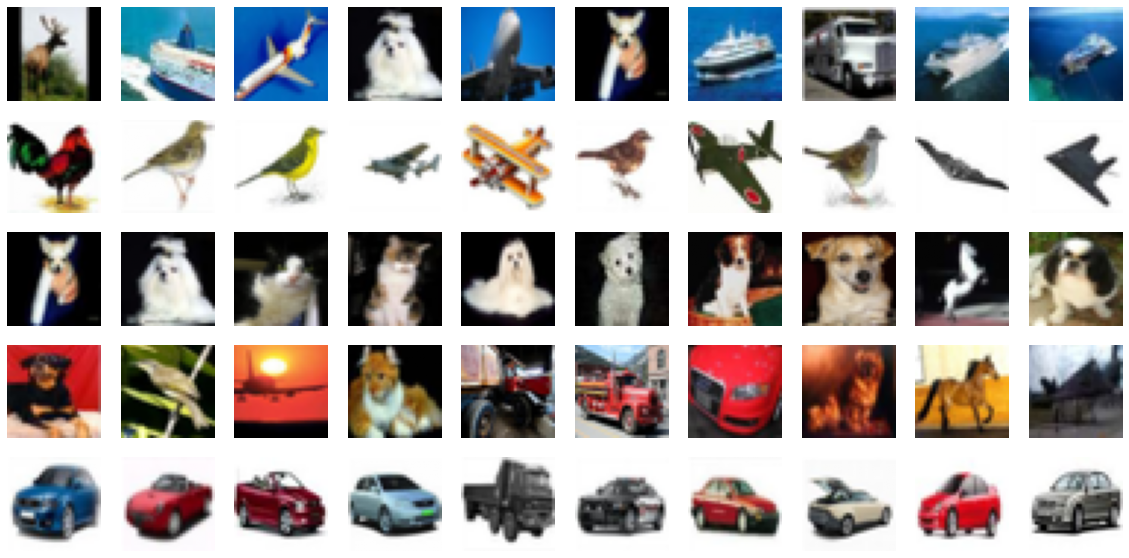

In [10]:
neuron_ns = [9, 57, 84, 201, 272]

nrows = len(neuron_ns)
samples = 10

fig, axs = plt.subplots(nrows=nrows, ncols=samples, figsize=(2*samples, 2*nrows))
for row, neuron_n in enumerate(neuron_ns):
    for col, img in enumerate(single_neuron_top_activations(encoder, X_train, neuron_n, samples)):
        ax = axs[row, col]
        ax.imshow(img)
        ax.axis('off')

Clearly neuron No. 9 is responsible for coding images containing color blue but not only such pictures activate it most. Number 57 is mostly activated by images of birds or aeroplanes with white background, similar to number 272, which also catches white background but with cars on it. Neuron No. 84 takes portraits of animals, mostly dogs and cats on black background and number 201 mostly catches color red.

# Classifiers

Now as we have trained the autoencoder, we're going to use its lower layers that makes codings as a basis for classifier that should be trained using small portion of images simulating lack of labeled data. Let's take 500.

In [11]:
from collections import Counter

def pick_train_sample(n_samples=500):
    num_train_sample = 500

    random_idxs = np.random.choice(len(X_train), size=num_train_sample, replace=False)
    X_train_sample = X_train[random_idxs]
    y_train_sample = y_train[random_idxs]
    return X_train_sample, y_train_sample
    
X_train_500, y_train_500 = pick_train_sample(500)
Counter(y_train_500.ravel())

Counter({1: 55, 0: 56, 8: 50, 4: 45, 2: 47, 5: 56, 9: 56, 3: 61, 7: 42, 6: 32})

The number of occurences of each class is not equal but it looks fair enough for our task.

Now let's prepare two classifiers of identical structure but one of them will use pretrained layers from the autoencoder while the other is going to be trained from random initialization.

In [12]:
classifier = keras.Sequential([
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(10, activation='softmax')
])

encoder = keras.models.clone_model(autoencoder.layers[0])
encoder.set_weights(autoencoder.layers[0].get_weights())
model_pretrained = keras.Sequential([encoder, classifier])
model_pretrained.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')]
)

history_pretrained = model_pretrained.fit(X_train_500, y_train_500, epochs=50, validation_data=(X_val, y_val), verbose=0)

In [13]:
classifier = keras.Sequential([
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(10, activation='softmax')
])

encoder = keras.models.clone_model(autoencoder.layers[0])
model_no_pretrained = keras.Sequential([encoder, classifier])
model_no_pretrained.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(0.001),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')]
)

history_no_pretrained = model_no_pretrained.fit(X_train_500, y_train_500, epochs=50, validation_data=(X_val, y_val), verbose=0)

In [14]:
plt.style.use('fivethirtyeight')

def plot_two_histories(history_pre, history_no_pre, figsize=(15, 6)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    epochs = np.array(history_pre.epoch)
    
    def plot_component(ax, name='loss'):
        train_comp1 = history_pre.history[name]
        val_comp1 = history_pre.history['val_' + name]
        train_comp2 = history_no_pre.history[name]
        val_comp2 = history_no_pre.history['val_' + name]    
        ax.set_xlabel('Epoch')

        ax.plot(epochs, train_comp1, color='blue', label='Train ' + name + ' pre')
        ax.plot(epochs, val_comp1, color='navy', label='Val ' + name + ' pre')
        ax.plot(epochs, train_comp2, color='green', label='Train ' + name + ' no pre')
        ax.plot(epochs, val_comp2, color='darkgreen', label='Val ' + name + ' no pre')
        
        all_values = train_comp1 + val_comp1 + train_comp2 + val_comp2
        ax.set_ylim(min(all_values), max(all_values))
        ax.set_ylabel(name.capitalize())
        ax.legend(loc=0, fontsize=16)
    
    plot_component(axs.ravel()[0], 'loss')
    plot_component(axs.ravel()[1], 'acc')

plot_two_histories(history_pretrained, history_no_pretrained)

Even though the codings looked promising because of its structured fashion, the classifier based on the pretrained layers couldn't manage to outperform randomly initialized one in the task. Both of them quickly overfits to the 500 samples.

Maybe approach based on different kind of networks, e.g. CNN, would lead into better results of using pretrained encoder in the classifier.